## COVID Paper Exploration Workshop

This workshop explores the use of [Azure Text Analytics](https://azure.microsoft.com/services/cognitive-services/text-analytics/?WT.mc_id=academic-49822-dmitryso) and [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/language-service/text-analytics-for-health/overview/?WT.mc_id=academic-49822-dmitryso) to get some insights from a large corpus of COVID medical papers. Full version of the workshop is available [here](http://eazify.net/paper-exploraton-workshop). 

Let's start by importing some of the required libraries:

In [1]:
import pandas as pd
import numpy as np
import datetime
import sys
import requests
import json
import time
import pickle
import bz2
import matplotlib.pyplot as plt


### Milestone 1: Getting the Dataset

In our example, we will only analyze a subset of paper abstracts. All paper metadata is available in **Metadata file** [Metadata.csv](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv). You need to:

1. Download [metadata.csv](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) file from Kaggle (you may need to log in / register first)
1. Place it in the `data` directory and unzip if needed.

> Notice that `metadata.csv` file is rather large, more than 1 Gb. This may cause file processing to be slow at some times. You should not be surprised, as we are dealing with rather large amounts of real world data!

We can then use Pandas library to load the file:

In [2]:
df = pd.read_csv('metadata.csv')

# You can also load the old version of the dataset directly over the network:
# df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')

df.head()

C:\Users\cosmo\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


**Pandas** is a very frequently used Python library to manipulate tabular data. You can [read more](https://github.com/microsoft/Data-Science-For-Beginners/tree/main/2-Working-With-Data/07-python) about using Pandas for data processing in our [Data Science for Beginners Curriculum](https://github.com/microsoft/Data-Science-For-Beginners/).

## Milestone 2: Initial Data Cleanup

Once we have the data, you need to do some data cleanup. First, let's see which columns we have:

In [3]:
df.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866605 entries, 0 to 866604
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          866605 non-null  object 
 1   sha               293894 non-null  object 
 2   source_x          866605 non-null  object 
 3   title             866168 non-null  object 
 4   doi               489751 non-null  object 
 5   pmcid             305461 non-null  object 
 6   pubmed_id         390515 non-null  object 
 7   license           866605 non-null  object 
 8   abstract          653755 non-null  object 
 9   publish_time      866369 non-null  object 
 10  authors           846465 non-null  object 
 11  journal           809253 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  400429 non-null  object 
 14  arxiv_id          11489 non-null   object 
 15  pdf_json_files    293894 non-null  object 
 16  pmc_json_files    24

All columns are not typed (have `dtype='object'`), but in some cases we want to perform some specific operations on them. Let's start by converting `publish_time` column to to `datetime`, and abstracts to `str`: 

In [7]:
df['publish_time'] = df['publish_time'].astype('datetime64')
df['abstract'] = df['abstract'].astype('str')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866605 entries, 0 to 866604
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   cord_uid          866605 non-null  object        
 1   sha               293894 non-null  object        
 2   source_x          866605 non-null  object        
 3   title             866168 non-null  object        
 4   doi               489751 non-null  object        
 5   pmcid             305461 non-null  object        
 6   pubmed_id         390515 non-null  object        
 7   license           866605 non-null  object        
 8   abstract          866605 non-null  object        
 9   publish_time      866369 non-null  datetime64[ns]
 10  authors           846465 non-null  object        
 11  journal           809253 non-null  object        
 12  mag_id            0 non-null       float64       
 13  who_covidence_id  400429 non-null  object        
 14  arxi

Now let's explore the range of dates of our publications. You can display the date range, or plot the histogram of publications by date (eg. how many publications were published at different dates):

<AxesSubplot:>

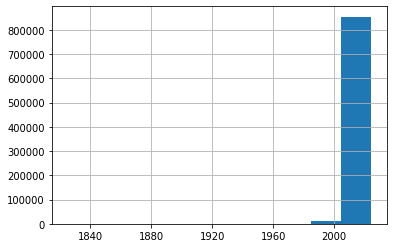

In [9]:
df['publish_time'].hist()

Notice that publications go back to as early as 19th century - this is because the dataset contains all publications on coronaviruses, even then pre-COVID ones. Let's focus on time period from January 2020 up to today. Filter out all the publications that are out of this range:

<AxesSubplot:>

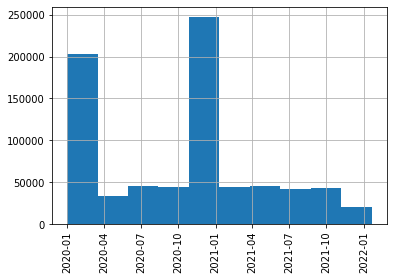

In [10]:
start_date = datetime.datetime(2020,1,1)
df = df[df['publish_time']>=start_date]
df = df[df['publish_time']<datetime.datetime.now()]
df['publish_time'].hist(xrot=90)

## Milestone 3: Creating and Using Text Analytics Endpoint

At this point, you should have your Azure subscription ready. Start by logging into [Azure Portal](http://portal.azure.com/?WT.mc_id=academic-49822-dmitryso).

Then, create an [Azure Cognitive Service for Language](https://docs.microsoft.com/azure/cognitive-services/language-service/overview/?WT.mc_id=academic-49822-dmitryso) cloud resource. You can start creating the resource by clicking [**HERE**](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesTextAnalytics) - it will take you to the corresponding page on the Azure Portal.

> Make sure to select **S - Standard** pricing tier, because Health Analytics is not available under the Free Tier.

Once you have created the resource, you should go to the portal and copy **Endpoint URL** and **Access key**:


In [11]:
endpoint = 'https://covidtext.cognitiveservices.azure.com/' 
key = 'd59201e6a8b3480cbd9a97c287fbbec0' 

To access the Cognitive Service for Language we need to install corresponding Python SDK:

* Analyze Sentiment
* Recognize Entities
* Recognize Linked Entities
* Recognize PII Entities
* Extract Key Phrases
* Detect Language
* Healthcare Entities Analysis
* Batch Analysis

[https://azuresdkdocs.blob.core.windows.net/$web/python/azure-ai-textanalytics/5.1.0b6/index.html](http://)

In [10]:
# !{sys.executable} -m pip install azure.ai.textanalytics

Now, let's create an object to call the service:

In [12]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

text_analytics_client = TextAnalyticsClient(
    endpoint=endpoint, 
    credential=AzureKeyCredential(key))

Text Analytics Client for healthcare entities

**entity**
* text
* normalized_text
* category
* subcategory
* offset
* confidence_score

**data_sources**
* entity_id
* name

**assertion**
* conditionality
* certianty
* association

Let's call the service and process first 3 abstracts. You can process up to 10 documents in a single call:

In [13]:
inp = [df['abstract'].iloc[i] for i in range(5)]

def analyze(arr):
    poller = text_analytics_client.begin_analyze_healthcare_entities(arr)
    return list(poller.result())

res = analyze(inp)
print(res)

[AnalyzeHealthcareEntitiesResult(id=0, entities=[HealthcareEntity(text=Dexmedetomidine, normalized_text=dexmedetomidine, category=MedicationName, subcategory=None, assertion=None, length=15, offset=12, confidence_score=1.0, data_sources=[HealthcareEntityDataSource(entity_id=C0113293, name=UMLS), HealthcareEntityDataSource(entity_id=N05CM18, name=ATC), HealthcareEntityDataSource(entity_id=0000016239, name=CHV), HealthcareEntityDataSource(entity_id=DB00633, name=DRUGBANK), HealthcareEntityDataSource(entity_id=4219, name=GS), HealthcareEntityDataSource(entity_id=d04505, name=MMSL), HealthcareEntityDataSource(entity_id=D020927, name=MSH), HealthcareEntityDataSource(entity_id=67VB76HONO, name=MTHSPL), HealthcareEntityDataSource(entity_id=C47479, name=NCI), HealthcareEntityDataSource(entity_id=67VB76HONO, name=NCI_FDA), HealthcareEntityDataSource(entity_id=008084, name=NDDF), HealthcareEntityDataSource(entity_id=48937, name=RXNORM), HealthcareEntityDataSource(entity_id=437750002, name=SNOMED

Now let's see all the entities we have extracted with corresponding entity types:

In [15]:
for ri in res:
    for e in ri.entities:
        print(f'{e.text} ({e.category}) [{e.confidence_score}]')

Dexmedetomidine (MedicationName) [1.0]
improve (Course) [0.96]
organ dysfunction (SymptomOrSign) [0.72]
critically (ConditionQualifier) [0.61]
ill (Diagnosis) [0.72]
randomized controlled trial (AdministrativeEvent) [0.9]
Dexmedetomidine (MedicationName) [1.0]
Sepsis (Diagnosis) [1.0]
Intensive Care Unit (CareEnvironment) [0.99]
ICU (CareEnvironment) [0.99]
Randomized (AdministrativeEvent) [0.58]
dexmedetomidine (MedicationName) [1.0]
severe (ConditionQualifier) [1.0]
sepsis (Diagnosis) [1.0]
improved (Course) [0.9]
survival (SymptomOrSign) [0.69]
sedated (TreatmentName) [0.95]
dexmedetomidine (MedicationName) [1.0]
sedation strategy (TreatmentName) [0.81]
dexmedetomidine (MedicationName) [1.0]
mechanically ventilated (TreatmentName) [0.99]
adult (Age) [0.97]
sepsis (Diagnosis) [1.0]
ICUs (CareEnvironment) [0.99]
study (AdministrativeEvent) [0.61]
Acute Physiology and Chronic Health Evaluation II (ExaminationName) [0.97]
APACHE II (ExaminationName) [0.97]
≥ (RelationalOperator) [1.0]
2

## Milestone 4: Processing Abstracts
 
 Keep in mind that some abstracts are not present (they will have 'NaN' )

> It is important to select abstracts randomly, because later on we will want to explore the change is treatment tactics over time, and we need to have uniform paper representation across all time period. Alternatively, to further minimize time/spend, you can select a time sub-interval (say, only year 2020), and then process random papers in that interval. 

Spend some time thinking about the way you will store the result of processing. You can add processing results as additional columns to the DataFrame, or you can use separate list/dictionary.

> You want to make sure that for each paper you keep essential info such as title and publication time, together with all entities and relations. 

In [238]:
sample_size = 150
sub_df = df[(df['abstract']!='nan') & (df['publish_time']<datetime.datetime(2020,9,1))].sample(n=sample_size)
batch_size = 10

store = { }
for i in range(0,sample_size,batch_size):
    z = list(sub_df.iloc[i:i+batch_size]['abstract'])
    r = analyze(z)
    for j,x in enumerate(r):
        store[sub_df.iloc[i+j]['cord_uid']] = \
          { 'title' : sub_df.iloc[i+j]['title'],
            'abstract' : sub_df.iloc[i+j]['abstract'],
            'publish_time' : sub_df.iloc[i+j]['publish_time'],
            'result' : x }
    print('.',end='')


......................................................................................................................................................

To make sure we can reuse the results later in case we need to restart the jupyter kernel or come back to the workshop next time, we can store the processing results on disk. Use `pickle` library for this. Here `store` is the variable name where the result of the processing is stored.

In [239]:
with bz2.BZ2File('processed_50.pkl.bz2','w') as f:
    pickle.dump(store,f)

Now at any time we can load the data and start data processing from there.

> If you do not want to wait until all the data is processed, you can open our pre-processed collection of papers right away using the code below:

In [16]:
with bz2.BZ2File('processed_1500.pkl.bz2','r') as f:
    store = pickle.load(f)

In [18]:
# print(store)

## Milestone 5: Get Top Symptoms, Medications and Diagnoses

To simplify further data processing, let's build the DataFrame of all entities. We shall go through all papers and populate a DataFrame as a result.

> Each entity has links to **ontologies**, which are structured hierarchies of medical terms. For example, [Unified Medical Language System](https://en.wikipedia.org/wiki/Unified_Medical_Language_System), or UMLS, contains codes for all medications, diagnoses, treatments, etc. Several terms, such as **SARS-Cov-2** and **COVID-19** can refer to the same entity, so to account for that we shall also extract and store UMLS ontology ID for each entity. 

In [19]:
def get_umls(entity):
    l = entity.data_sources if entity.data_sources else []
    r = [x.entity_id for x in l if x.name=='UMLS']
    return r[0] if len(r)>0 else None

In [20]:
entities = pd.DataFrame([ { 'text' : x.text, 'category' : x.category, 'umls' : get_umls(x), 
                            'publish_time' : p['publish_time'], 'title' : p['title'] } 
             for p in store.values()
             for x in p['result'].entities ])
entities.head()

,text,category,umls,publish_time,title
0,Covid-19,Diagnosis,C5203670,2020-01-01,The Hopeless University: Intellectual Work at ...
1,scarring,SymptomOrSign,C2004491,2020-01-01,The Hopeless University: Intellectual Work at ...
2,COVID-19,Diagnosis,C5203670,2020-01-01,Chest CT in COVID-19 pneumonia: A review of cu...
3,chest computed tomography (CT,ExaminationName,None,2020-01-01,Chest CT in COVID-19 pneumonia: A review of cu...
4,emergency departments,CareEnvironment,None,2020-01-01,Chest CT in COVID-19 pneumonia: A review of cu...


Let's explore which entity types are most commonly observed:

In [21]:
entities['category'].value_counts()

Diagnosis               11013
ExaminationName          4959
TreatmentName            4109
SymptomOrSign            3103
MeasurementValue         1785
GeneOrProtein            1780
Time                     1672
AdministrativeEvent      1479
ConditionQualifier       1468
BodyStructure            1178
MedicationName           1082
Course                   1050
HealthcareProfession      817
CareEnvironment           805
Age                       796
MeasurementUnit           594
MedicationClass           563
RelationalOperator        442
Gender                    440
FamilyRelation            302
Date                      273
Expression                216
MutationType              169
Dosage                    145
Direction                 106
Frequency                  96
MedicationRoute            69
Variant                    66
Allergen                   24
MedicationForm             23
ConditionScale             20
Name: category, dtype: int64

To be able to find top-mentioned diagnoses and symptoms, we will build a frame that contains number of mentions for each of the entity, based on its ontology ID.

In [22]:
first = lambda x : list(x)[0]

entcount = entities.groupby('umls').agg({ 'text' : first, 'category' : first, 'umls' : len }).rename(columns={ 'umls' : 'count' })
entcount.head()

,text,category,count
umls,,,
C0000726,abdomen,BodyStructure,3
C0000727,acute abdomen,Diagnosis,1
C0000737,abdominal pain,SymptomOrSign,6
C0000768,birth defects,Diagnosis,4
C0000833,abscesses,SymptomOrSign,2


From this DataFrame, we can easily find out top mentioned diagnoses and symptoms:

In [23]:
for c in ['Diagnosis','SymptomOrSign','TreatmentName','MedicationName','MedicationClass']:
    print(c)
    display(entcount[entcount['category']==c].sort_values(by='count',ascending=False).head(10))

Diagnosis


,text,category,count
umls,,,
C5203670,Covid-19,Diagnosis,3790
C3714514,infection,Diagnosis,502
C0012634,disease,Diagnosis,499
C0011065,death,Diagnosis,215
C0042769,virus,Diagnosis,213
C0206750,coronavirus,Diagnosis,202
C0026565,mortality,Diagnosis,167
C0006826,cancer,Diagnosis,121
C5203676,severe acute respiratory syndrome coronavirus 2,Diagnosis,116


SymptomOrSign


,text,category,count
umls,,,
C1457887,symptoms,SymptomOrSign,154
C0015967,Fever,SymptomOrSign,91
C0229992,mental,SymptomOrSign,74
C0080194,strain,SymptomOrSign,67
C0231221,asymptomatic,SymptomOrSign,51
C0038435,stress,SymptomOrSign,51
C0013404,shortness of breath,SymptomOrSign,48
C0010200,cough,SymptomOrSign,42
C3827002,ground-glass opacities,SymptomOrSign,26


TreatmentName


,text,category,count
umls,,,
C0087111,treatments,TreatmentName,285
C0042196,vaccine,TreatmentName,121
C0013227,medications,TreatmentName,102
C0543467,surgery,TreatmentName,83
C0199176,prevention,TreatmentName,68
C0042210,vaccines,TreatmentName,61
C1443871,PPE,TreatmentName,55
C0184661,interventions,TreatmentName,55
C0034386,quarantine,TreatmentName,53


MedicationName


,text,category,count
umls,,,
C0020336,hydroxychloroquine,MedicationName,99
C0008269,chloroquine,MedicationName,43
C0939237,lopinavir + ritonavir,MedicationName,28
C4726677,Remdesivir,MedicationName,27
C1609165,tocilizumab,MedicationName,27
C0052796,azithromycin,MedicationName,18
C0292818,ritonavir,MedicationName,18
C0028066,nifedipine,MedicationName,13
C0915082,Isopulegol,MedicationName,13


MedicationClass


,text,category,count
umls,,,
C0003451,antivirals,MedicationClass,56
C0003232,antibiotics,MedicationClass,34
C0001617,corticosteroid,MedicationClass,33
C0038317,steroids,MedicationClass,18
C0003280,anticoagulation,MedicationClass,18
C0040615,antipsychotic,MedicationClass,13
C0003015,angiotensin-converting enzyme inhibitors,MedicationClass,11
C1963724,antiretroviral therapy,MedicationClass,10
C0521942,angiotensin II receptor blockers,MedicationClass,10


For the sake of interest, let's build the word cloud of all diagnoses. You can use [this tutorial](https://www.datacamp.com/community/tutorials/wordcloud-python) as a guideline.

In [25]:
# Install wordcloud using either of those two methods if you do not have it:
# %conda install -c conda-forge wordcloud
# %{sys.executable} -m pip install wordcloud
import wordcloud as wc

(-0.5, 399.5, 199.5, -0.5)

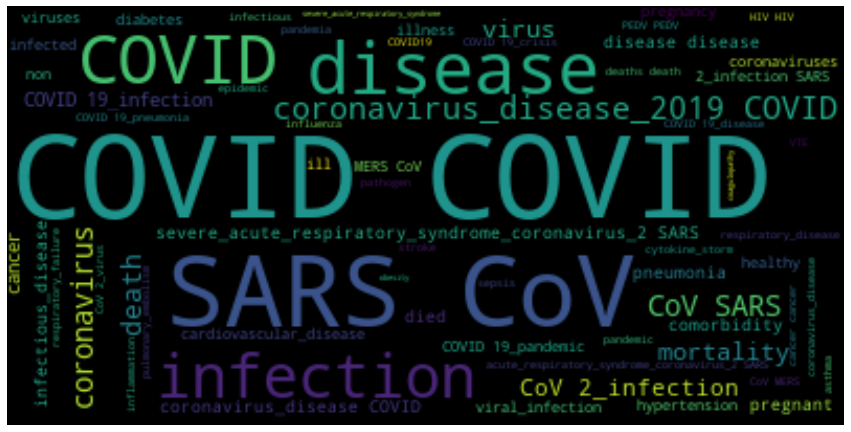

In [26]:
diag_text = ' '.join(entities[entities['category'] == 'Diagnosis']['text'].apply(lambda s: s.replace(' ','_').replace('dities','dity')))
plt.figure(figsize=(15,10))
plt.imshow(wc.WordCloud().generate(diag_text),interpolation='bilinear')
plt.axis('off')

## Milestone 6: Visualize Change in Treatment Strategies

In addition to calculating the total count of mentions, you can see how they are distributed by month, and this detects changes in treatment strategies. Select the top medications/strategies and compute the distribution of their mentions by months (or weeks). First, get the list of top-5 UMLS IDs for medications and medication classes (AKA treatment strategies):

In [27]:
top_med_ids = list(entcount[entcount['category'] == 'MedicationName'].sort_values(by='count',ascending=False).head(5).index)
top_cls_ids = list(entcount[entcount['category'] == 'MedicationClass'].sort_values(by='count',ascending=False).head(5).index)

Now we can select only those entities that have umls id's within the top id list:

In [28]:
meds = entities[entities['umls'].isin(top_cls_ids)]
meds['month'] = meds['publish_time'].astype('datetime64[M]')
medhist = meds.groupby(['month','umls']).agg({'text' : 'count'})
medhist

C:\Users\cosmo\AppData\Local\Temp\ipykernel_28108\1035193559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds['month'] = meds['publish_time'].astype('datetime64[M]')


text
month      umls          
2020-01-01 C0001617    12
           C0003232    17
           C0003280    16
           C0003451    43
           C0038317     1
2020-02-01 C0003232     1
2020-03-01 C0003232     9
           C0003451     1
2020-04-01 C0003451     4
           C0038317     1
2020-05-01 C0001617     9
           C0003232     2
           C0003280     1
           C0003451     4
2020-06-01 C0001617     2
           C0003232     3
           C0003451     2
2020-07-01 C0001617     5
           C0003232     1
           C0003280     1
           C0003451     1
           C0038317     1
2020-08-01 C0001617     5
           C0003232     1
           C0003451     1
           C0038317    15

Finally, plot the result. 

> You may use the bar plot or a series of line plots, and you many need to reset the index (using `reset_index()`) and layout indexing differently (using `pivot`). 

In [30]:
medhist.reset_index().pivot(index='month',columns='umls',values='text')

umls,C0001617,C0003232,C0003280,C0003451,C0038317
month,,,,,
2020-01-01,12.0,17.0,16.0,43.0,1.0
2020-02-01,NaN,1.0,NaN,NaN,NaN
2020-03-01,NaN,9.0,NaN,1.0,NaN
2020-04-01,NaN,NaN,NaN,4.0,1.0
2020-05-01,9.0,2.0,1.0,4.0,NaN
2020-06-01,2.0,3.0,NaN,2.0,NaN
2020-07-01,5.0,1.0,1.0,1.0,1.0
2020-08-01,5.0,1.0,NaN,1.0,15.0


(0.0, 10.0)

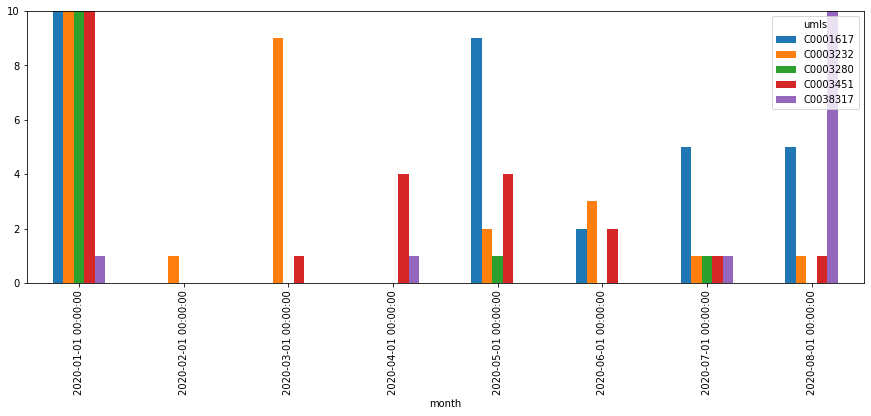

In [32]:
ax = medhist.reset_index().pivot(index='month',columns='umls',values='text').plot.bar(figsize=(15,5))
ax.set_ylim([0,10])

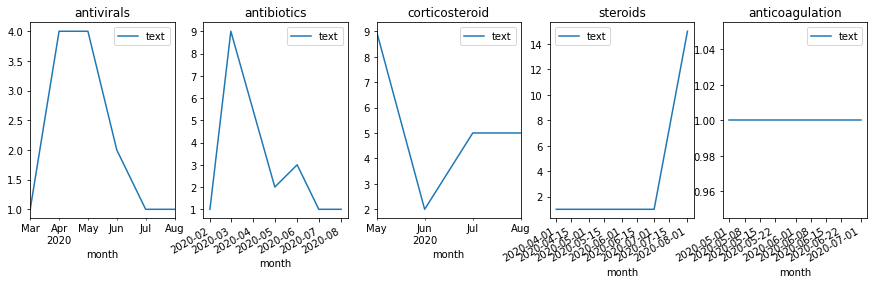

In [33]:
df = medhist.reset_index()
df = df[df['month']>datetime.datetime(2020,1,1)].set_index('month')
fig, ax = plt.subplots(1,5,figsize=(15,4))


for i,(k,v) in enumerate(
    { 'C0003451' : 'antivirals', 'C0003232' : 'antibiotics', 
      'C0001617' : 'corticosteroid', 'C0038317' : 'steroids', 'C0003280' : 'anticoagulation' }.items()):
    df[df['umls']==k].plot(ax=ax[i],title=v)

## Milestone 7: Visualize Co-occurrence of Terms

It is interesting to see which terms occur together within one paper, because it can give us an idea about relationships between, for example, diagnoses and medications, or symptoms and treatments. You should also be able to see which medications are often used together, and which symptoms occur together.

You can use two types of diagrams for that:

* A **Sankey diagram** allows us to investigate relations between two types of terms, eg. diagnosis and treatment
* A **Chord diagram** helps to visualize co-occurrence of terms of the same type (eg. which medications are mentioned together)

To plot both diagrams, we need to compute co-occurrence matrix, which in the row i and column j contains number of co-occurrences of terms i and j in the same abstract (one can notice that this matrix is symmetric).


In [4]:
# medclass_ontology = {
#     'C0003451' : ('antivirals',0),
#     'C0003232' : ('antibiotics',1),
#     'C0001617' : ('corticosteroid',2),
#     'C0038317' : ('steroids',2),
#     'C0003280' : ('anticoagulation',3) }

# diag_ontology = {
#     'C5203670' : ('Covid-19',0),
#     'C3714514' : ('infection',1),
#     'C0011065' : ('death',2),
#     'C0042769' : ('virus',3),
#     'C0206750' : ('coronavirus',3),
#     'C0026565' : ('mortality',2),
#     'C0006826' : ('cancer',4),
#     'C5203676' : ('SARS',5) }

# med_ontology = {
#     'C0020336' : ('hydroxychloroquine',0),
#     'C0008269' : ('chloroquine',0),
#     'C0939237' : ('lopinavir + ritonavir',1),
#     'C4726677' : ('Remdesivir',2),
#     'C1609165' : ('tocilizumab',3),
#     'C0052796' : ('azithromycin',4),
#     'C0292818' : ('ritonavir',5) }

In [33]:
# def get_matrix(cat1, cat2):
#     d1 = {i:j[1] for i,j in cat1.items()}
#     d2 = {i:j[1] for i,j in cat2.items()}
#     s1 = set(cat1.keys())
#     s2 = set(cat2.keys())
#     a = np.zeros((len(cat1),len(cat2)))
#     for ent in store.values():
#         e = set(get_umls(x) for x in ent['result'].entities)
#         for j in e & s1:
#             for k in e & s2 :
#                 a[d1[j],d2[k]] += 1
#     return a

# print(get_matrix(medclass_ontology,diag_ontology))

[[33. 14.  9. 14.  1.  6.  0.  0.]
 [ 9.  4.  4.  3.  0.  1.  0.  0.]
 [15.  3.  3.  4.  0.  0.  0.  0.]
 [10.  3.  5.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]



To actually plot the diagrams, we can use [Plotly](https://plotly.com/python/) graphics library. This process is well described [here](https://plotly.com/python/sankey-diagram/).

In [37]:
#To use plotly, first install it using the commented command below

# !{sys.executable} -m pip install plotly
# import plotly.graph_objects as go

In [2]:
# def transform_ontology(o):
#     transformed = {}
#     for j in o.values():
#         if j[1] not in transformed:
#             transformed[j[1]]=j[0]
#     return transformed

# def sankey (cat1, cat2, title, highlight1 = [], highlight2 = [], threshold=0):
#     o1 = transform_ontology(cat1)
#     o2 = transform_ontology(cat2)
    
#     all_nodes = list(o1.values()) + list(o2.values())
#     #labels = list(cat1.values()) + list(cat2.values())
#     source_indices = list(range(len(o1)))
#     target_indices = list(range(len(o1),len(o1)+len(o2)))
#     m = get_matrix(cat1, cat2)

#     s, t, v, c = [], [], [], []

#     for i in range(len(o1)):
#         for j in range(len(o2)):
#             if m[i,j] > threshold:
    #             s.append(i)
    #             t.append(len(o1)+j)
    #             v.append(m[i,j])
    #             c.append('magenta' if j in highlight2 or i in highlight1 else 'lightgrey')

    # fig = go.Figure(data=[go.Sankey(
    #     # Define nodes
    #     node = dict(
    #     pad = 40,
    #     thickness = 40,
    #     line = dict(color = "black", width = 1.0),
    #     label =  all_nodes,
    #     #color =  "blue"
    #     ),

    #     # Add links
    #     link = dict(
    #     source =  s,
    #     target =  t,
    #     value =  v,
    #     color = c
    # ))])

    # fig.update_layout(title_text=title,
    #                 font_size=13)
    # fig.show()

# sankey(medclass_ontology,diag_ontology,'Medication classes and diagnoses',highlight2=[0])

To plot the chord diagram, you can use the [Holoviews](https://holoviews.org/) library. You may need to install it first.

In [3]:
# !conda install -c pyviz holoviews bokeh

# import holoviews as hv
# hv.extension("bokeh")

In [346]:
# def chord(cat,name):
#     matrix = get_matrix(cat,cat)
#     onto_map = transform_ontology(cat)
#     df = pd.DataFrame([ { 'src' : onto_map[i], 'dst' : onto_map[j], 'count' : (matrix[i,j]) } for i in range(len(onto_map)) for j in range(i+1,len(onto_map)) if matrix[i,j]>=1])
#     meds = hv.Dataset(pd.DataFrame(onto_map.values(),columns=[name]))
#     return (df,meds)

# %opts Chord [height=500 width=500 title="Diagnosis" labels="Diagnosis"]
# %opts Chord (node_color="Diagnosis" edge_color='src' edge_cmap='Category20')
# hv.Chord(chord(diag_ontology,"Diagnosis"))

:Chord   [src,dst]   (count)

## What to do next

Now that you have learnt how you can use knowledge extraction from text, you can try to apply this to different problems. For different knowledge domains, however, you would need to train your own NER neural network model, and for that you will also need a dataset. [Custom Named Entity Recognition](https://docs.microsoft.com/azure/cognitive-services/language-service/custom-named-entity-recognition/overview/?WT.mc_id=academic-49822-dmitryso) service can help you do that. However, [Text Analytics Service](https://azure.microsoft.com/en-us/services/cognitive-services/text-analytics/?WT.mc_id=academic-49822-dmitryso) also has some [pre-built entity extraction mechanism](https://docs.microsoft.com/azure/cognitive-services/language-service/named-entity-recognition/concepts/named-entity-categories/?WT.mc_id=academic-49822-dmitryso), as well as keyword extraction.

Some of the projects you may want to build:

* Analyze a blog or social network posts and get the idea of different topics that author is writing about. See how interests change over time, as well as the mood. You can use the blog of [Scott Hanselman](https://www.hanselman.com/), it goes back to [2002](https://www.hanselman.com/blog/archive/2002).
* Analyze [COVID 19 twitter feed](https://github.com/thepanacealab/covid19_twitter) to see if you can extract changes in major topics on twitter.
* Analyze your e-mail archive to see how the topics you discuss and your mood change over time. Most e-mail clients allow you to export your e-mails to plain text or CSV format (here is an [example for Outlook](https://support.microsoft.com/office/import-and-export-outlook-email-contacts-and-calendar-92577192-3881-4502-b79d-c3bbada6c8ef/?WT.mc_id=academic-49822-dmitryso)).





